**Porcentaje de hogares que tuvieron cambiarse de vivienda o lugar de residencia (hogares) por situaciones de violencia e inseguridad**


In [7]:
rm(list = ls())

libraries <- c("tidyverse",
               "srvyr")

installed_packages <- rownames(installed.packages())
libraries_to_install <- setdiff(libraries, installed_packages)

if (length(libraries_to_install) > 0) {
  install.packages(libraries_to_install)
}

lapply(libraries, library, character.only = TRUE)


[[1]]
 [1] "srvyr"     "lubridate" "forcats"   "stringr"   "dplyr"     "purrr"    
 [7] "readr"     "tidyr"     "tibble"    "ggplot2"   "tidyverse" "stats"    
[13] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "srvyr"     "lubridate" "forcats"   "stringr"   "dplyr"     "purrr"    
 [7] "readr"     "tidyr"     "tibble"    "ggplot2"   "tidyverse" "stats"    
[13] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"

In [8]:
#Leeer tabla de victimas----
leer_envipe_vic <- function(anio){
  # Lista de URLs por año
  urls <- list(
    "2016" = "https://www.inegi.org.mx/contenidos/programas/envipe/2016/microdatos/bd_envipe2016_dbf.zip",
    "2017" = "https://www.inegi.org.mx/contenidos/programas/envipe/2017/microdatos/bd_envipe2017_dbf.zip",
    "2018" = "https://www.inegi.org.mx/contenidos/programas/envipe/2018/microdatos/bd_envipe2018_dbf.zip",
    "2019" = "https://www.inegi.org.mx/contenidos/programas/envipe/2019/microdatos/bd_envipe2019_dbf.zip",
    "2020" = "https://www.inegi.org.mx/contenidos/programas/envipe/2020/microdatos/bd_envipe_2020_dbf.zip",
    "2021" = "https://www.inegi.org.mx/contenidos/programas/envipe/2021/microdatos/bd_envipe_2021_dbf.zip", 
    "2022" = "https://www.inegi.org.mx/contenidos/programas/envipe/2022/microdatos/bd_envipe_2022_dbf.zip", 
    "2023" = "https://www.inegi.org.mx/contenidos/programas/envipe/2023/microdatos/bd_envipe_2023_dbf.zip", 
    "2024" = "https://www.inegi.org.mx/contenidos/programas/envipe/2024/microdatos/bd_envipe_2024_dbf.zip")
  
  temp_zip <- tempfile(fileext = ".zip")
  temp_dir <- tempdir()
  options(timeout = 800)
  download.file(urls[[as.character(anio)]], temp_zip, mode = "wb")
  unzip(temp_zip, exdir = temp_dir)
  
  envipe_datos <- list.files(temp_dir, pattern = "TPer_Vic1.dbf", 
                              full.names = TRUE, recursive = TRUE)
  
  datos <- foreign::read.dbf(envipe_datos)
   
  unlink(temp_zip)
  unlink(list.files(temp_dir, full.names = TRUE), recursive = TRUE)
  
  return(datos)
}


In [9]:
#Ajustar los datos a las variables que quiero
creacion_de_variable <- function(anio) {
  
  objeto_datos <- get(paste0("tpv", anio))
  
  mutate(objeto_datos, 
         HOG = ifelse(!FAC_HOG_AM %in% "0",1,0), 
         cambio_viv = ifelse(AP4_11_10 %in% c("1","2"), "población con respuesta","sin respuesta"))|>
    filter(cambio_viv == "población con respuesta")|>
    mutate(cambio_viv_violencia = ifelse(cambio_viv == "población con respuesta" & AP4_11_10 == "1", "Se cambio de residencia", "No se cambio de residencia"), 
           FAC_HOG_AM= as.numeric(FAC_HOG_AM))
}

In [10]:
#Función para definir el diseño muestral----
diseño_muestral <- function(anio) {
  
  objeto_datos <- get(paste0("tpv_", anio))
  
  as_survey_design(objeto_datos,
                   strata = EST_DIS,
                   weights = FAC_HOG_AM,
                   ids = UPM_DIS,
                   nest = TRUE)
}


In [11]:
resultados_inseguridad <- function(anio) {
  datos <- get(paste0("inseg_viv_", anio))
  
  datos_dm <- datos |>
    group_by(cambio_viv_violencia) |>
    summarise(tot_p_inseg_viv = survey_total(vartype = "cv"),
              porcentaje = survey_prop(vartype = "cv") * 100)|>
    filter(cambio_viv_violencia == "Se cambio de residencia")|>
    select(cambio_viv_violencia, porcentaje, porcentaje_cv)|>
    mutate(ano = anio)
  
  return(datos_dm)
}


In [12]:
#Leer datos del la ENVIPE
tpv2016 <- leer_envipe_vic(2016) |>  
  filter(AREAM == "01")
tpv2017 <- leer_envipe_vic(2017) |>  
  filter(AREAM == "01")
tpv2018 <- leer_envipe_vic(2018) |>  
  filter(AREAM == "01")
tpv2019 <- leer_envipe_vic(2019) |>  
  filter(AREAM == "01")
tpv2020 <- leer_envipe_vic(2020) |>  
  filter(AREAM == "01")
tpv2021 <- leer_envipe_vic(2021) |>  
  filter(AREAM == "01")
tpv2022 <- leer_envipe_vic(2022) |>  
  filter(AREAM == "01")
tpv2023 <- leer_envipe_vic(2023) |>  
  filter(AREAM == "01")
tpv2024 <- leer_envipe_vic(2024) |>  
  filter(AREAM == "01")


In [13]:
#Aplicar la generaación de campos para las variables de interes----
tpv_2016<-creacion_de_variable(2016)
tpv_2017<-creacion_de_variable(2017)
tpv_2018<-creacion_de_variable(2018)
tpv_2019<-creacion_de_variable(2019)
tpv_2020<-creacion_de_variable(2020)
tpv_2021<-creacion_de_variable(2021)
tpv_2022<-creacion_de_variable(2022)
tpv_2023<-creacion_de_variable(2023)
tpv_2024<-creacion_de_variable(2024)


In [14]:
#Aplicar el diseño muestral para N años----
inseg_viv_2016 <-diseño_muestral(2016)
inseg_viv_2017 <-diseño_muestral(2017)
inseg_viv_2018 <-diseño_muestral(2018)
inseg_viv_2019 <-diseño_muestral(2019)
inseg_viv_2020 <-diseño_muestral(2020)
inseg_viv_2021 <-diseño_muestral(2021)
inseg_viv_2022 <-diseño_muestral(2022)
inseg_viv_2023 <-diseño_muestral(2023)
inseg_viv_2024 <-diseño_muestral(2024)

In [15]:
p_inseg_viv_2016 <- resultados_inseguridad(2016)
p_inseg_viv_2017 <- resultados_inseguridad(2017)
p_inseg_viv_2018 <- resultados_inseguridad(2018)
p_inseg_viv_2019 <- resultados_inseguridad(2019)
p_inseg_viv_2020 <- resultados_inseguridad(2020)
p_inseg_viv_2021 <- resultados_inseguridad(2021)
p_inseg_viv_2022 <- resultados_inseguridad(2022)
p_inseg_viv_2023 <- resultados_inseguridad(2023)
p_inseg_viv_2024 <- resultados_inseguridad(2024)

In [16]:
inseg_vivienda <-p_inseg_viv_2016|>
  bind_rows(p_inseg_viv_2017, 
            p_inseg_viv_2018, 
            p_inseg_viv_2019, 
            p_inseg_viv_2020, 
            p_inseg_viv_2021,
            p_inseg_viv_2022, 
            p_inseg_viv_2023, 
            p_inseg_viv_2024)|>
  select(porcentaje,porcentaje_cv, ano)|>
  mutate(tipo = "Observado")

inseg_vivienda


inseg_vivienda_2024 <- inseg_vivienda |> filter(ano == 2024)
inseg_vivienda_2016 <- inseg_vivienda |> filter(ano == 2016)

porcentaje,porcentaje_cv,ano,tipo
<dbl>,<dbl>,<dbl>,<chr>
0.5445647,22.65871,2016,Observado
0.8511931,14.25700,2017,Observado
0.9526708,13.81204,2018,Observado
2.2724199,10.66799,2019,Observado
1.4637549,11.41228,2020,Observado
1.0784626,13.78512,2021,Observado
0.4904186,17.13199,2022,Observado
0.4384359,18.52074,2023,Observado
1.1908910,13.05406,2024,Observado


In [17]:
##ESCENARIOS TENDENCIALES 2030,2035,2045
# Tasa de variación
tcma<-((inseg_vivienda_2024$porcentaje /inseg_vivienda_2016$porcentaje)^(1/(2024-2016)) - 1) 
tcma

inseg_vivienda_base <- inseg_vivienda |>
  filter(ano == 2024) |>
  pull(porcentaje)

inseg_vivienda_base

# Años a proyectar
años <- c(2030,2035,2045)
año_base <- 2024

tendencia_base <- data.frame(ano = años,
                             porcentaje = round(inseg_vivienda_base * (1 + 1/3*tcma) ^ (años - año_base), 2),
                             tipo = "Inercial")


tendecia_deseable<-data.frame(ano = años,
                              porcentaje = round(inseg_vivienda_base * (1 + -1/2*tcma) ^ (años - año_base), 2),
                              tipo = "Deseable")


tendecia_transformadora <-data.frame(ano = años,
                                     porcentaje = round(inseg_vivienda_base * (1 + -3/4*tcma) ^ (años - año_base), 2),
                                     tipo = "Transformador")


inseg_vivienda_tendencias <- inseg_vivienda|>
  bind_rows(tendencia_base,tendecia_deseable, 
            tendecia_transformadora)|>
  select(ano, porcentaje, tipo)

inseg_vivienda_tendencias

[1] 0.1027519

[1] 1.190891

ano,porcentaje,tipo
<dbl>,<dbl>,<chr>
2016,0.5445647,Observado
2017,0.8511931,Observado
2018,0.9526708,Observado
2019,2.2724199,Observado
2020,1.4637549,Observado
2021,1.0784626,Observado
2022,0.4904186,Observado
2023,0.4384359,Observado
2024,1.1908910,Observado


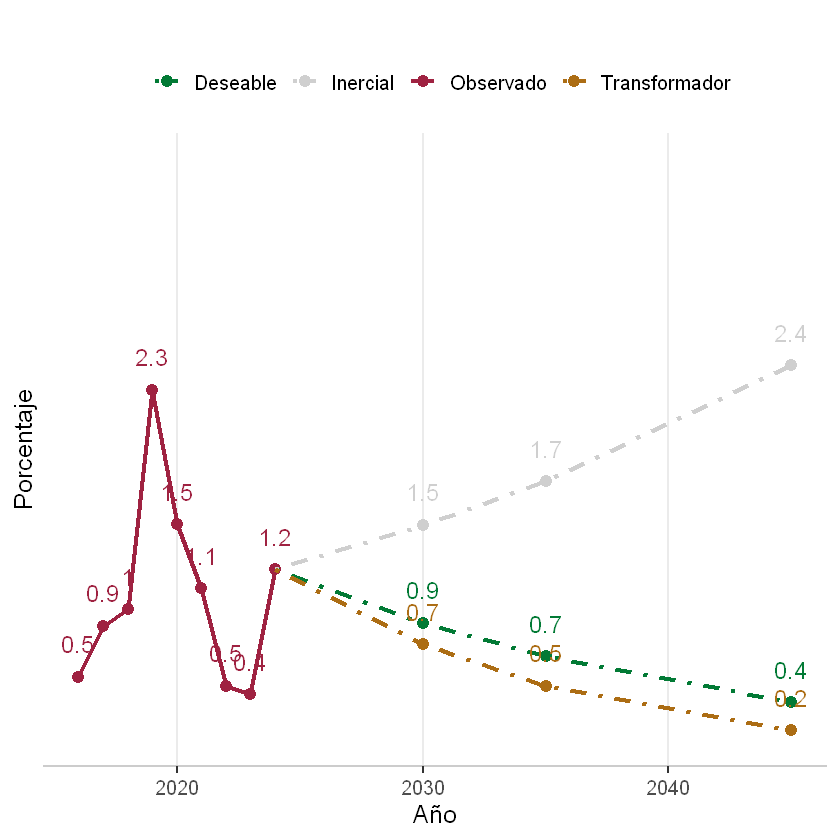

In [ ]:
lineas <- bind_rows(data.frame(ano = c(2024, 2030),
                               porcentaje = c(inseg_vivienda_tendencias$porcentaje[inseg_vivienda_tendencias$ano == 2024 & inseg_vivienda_tendencias$tipo == "Observado"],
                                              inseg_vivienda_tendencias$porcentaje[inseg_vivienda_tendencias$ano == 2030 & inseg_vivienda_tendencias$tipo == "Inercial"]),
                               tipo = "Inercial"),
                    data.frame(ano = c(2024, 2030),
                               porcentaje = c(inseg_vivienda_tendencias$porcentaje[inseg_vivienda_tendencias$ano == 2024 & inseg_vivienda_tendencias$tipo == "Observado"], 
                                              inseg_vivienda_tendencias$porcentaje[inseg_vivienda_tendencias$ano == 2030 & inseg_vivienda_tendencias$tipo == "Deseable"]),
                               tipo = "Deseable"), 
                    data.frame(ano = c(2024, 2030),
                               porcentaje = c(inseg_vivienda_tendencias$porcentaje[inseg_vivienda_tendencias$ano == 2024 & inseg_vivienda_tendencias$tipo == "Observado"], 
                                              inseg_vivienda_tendencias$porcentaje[inseg_vivienda_tendencias$ano == 2030 & inseg_vivienda_tendencias$tipo == "Transformador"]),
                               tipo = "Transformador"))


paleta_colores <- c("Observado" = "#9F2241",
                    "Inercial" = "#cfcfcf" ,
                    "Deseable" = "#027A35", 
                    "Transformador" = "#AC6D14")

linetypes <- c("Observado" = "solid",
               "Inercial" = "dotdash",
               "Deseable" = "dotdash", 
               "Transformador" = "dotdash")


# Gráfico con etiquetas y eje Y personalizado
ggplot(inseg_vivienda_tendencias, aes(x = ano, y = porcentaje, group = tipo, color = tipo, linetype = tipo)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 3) +
  geom_line(data = lineas, aes(x = ano, y = porcentaje, group = tipo), linewidth = 1.2) +
  geom_text(aes(label = round(porcentaje, 1)),
            position = position_nudge(y = 0.2),
            size = 5, show.legend = FALSE) +
  scale_color_manual(values = paleta_colores) +
  scale_linetype_manual(values = linetypes) +
  scale_y_continuous(breaks = seq(0, max(inseg_vivienda_tendencias$porcentaje, na.rm = TRUE) +100, by = 50),
                     labels = function(x) paste0(x, ""),
                     expand = expansion(mult = c(0.09,0.5))) +
  labs(title = "",
       x = "Año",
       y = "Porcentaje",
       color = "",
       linetype = "") +
  theme_bw(base_size = 15) +
  theme( panel.grid.minor.y = element_line(color = "gray80", linetype = "dotted"),
         panel.grid.minor.x = element_blank(),
         panel.grid.major.y = element_blank(),
         panel.border = element_blank(),
         axis.line = element_line(color = "gray80"),
         legend.position = "top",
         plot.caption = element_text(hjust = 100))

ggsave("inseg_vivienda_tendencias.png", width = 8, height = 5, dpi = 300)